In [1]:
#!/usr/bin/env python3

import chardet
import csv
import json
import nibabel as nib
import nilearn
import numpy as np
import os
import pandas as pd
import random
import regex as re
import string
import struct
import sys

from chardet import UniversalDetector as udet
from collections import Counter
from functools import reduce
from io import StringIO
from io import BytesIO
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os import listdir as ls
from os.path import join as pjoin
from pandas import DataFrame as df
from string import printable
from typing import Union
from zipfile import ZipFile
from tqdm import tqdm
from unidecode import unidecode
from operator import itemgetter

from nilearn.glm.first_level import make_first_level_design_matrix as mfldm
from nilearn.glm.first_level import first_level_from_bids
from nilearn.plotting import plot_design_matrix as plot1dm

from sniffbytes import flatten
from sniffbytes import loadfiles
from sniffbytes import loadimages

from bidsify_utils import bidsify_load_scans
from bidsify_utils import bidsify_names

from json_read import json_read

import sniffbytes as snif

from scanzip import scanzip



from removeEmptyFolders import removeEmptyFolders
from multiple_replace import multiple_replace



/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
cimaq_dir = xpu('~/../../data/simexp/datasets/cimaq_03-19/')
drv_dir = pjoin(cimaq_dir, 'derivatives/CIMAQ_fmri_memory/data')
print("#"*79)


###############################################################################


### Nilearn First Level Matrix parameters explained:
- https://nilearn.github.io/modules/generated/nilearn.glm.first_level.make_first_level_design_matrix.html#nilearn.glm.first_level.make_first_level_design_matrix


#### The pd.DataFrame instance might have these keys:
##### "onset" and "duration" are mandatory

- ‘onset’: column to specify the start time of each events in
   seconds. An error is raised if this key is missing.

- ‘trial_type’: column to specify per-event experimental conditions
   identifier. If missing each event are labelled ‘dummy’ and considered to form a unique condition.

- ‘duration’: column to specify the duration of each events in
   seconds. If missing the duration of each events is set to zero.

- ‘modulation’: column to specify the amplitude of each
   events. If missing the default is set to ones(n_events).



### Why Encoding Type Matters

- See how encoding type formats the same "null-byte value" differently \
  when printed to be human readable

In [3]:
display("\x00".encode('utf8'), "\x00".encode('utf16'), "\x00".encode('utf32'),
        "".encode('utf8'), "".encode('utf16'), "".encode('utf32'))

b'\x00'

b'\xff\xfe\x00\x00'

b'\xff\xfe\x00\x00\x00\x00\x00\x00'

b''

b'\xff\xfe'

b'\xff\xfe\x00\x00'

In [33]:
retest = list((snif.bytes2df(val['bsheets'].values[0]),
                     snif.bytes2df(val['bsheets'].values[1]),
                     snif.bytes2df(val['bsheets'].values[2]))
                                   
#                           snif.bytes2df(val['bsheets'].values[0]).drop(
#                               columns = [0, 1, 2, 3, 4, 6],
#                               index = 0).rename(columns = {5: 'stim_onset',
#                                                            7: 'fix_onset',
#                                                            8: 'duration'})],
#                          axis = 1).to_csv(pjoin(
#                    os.getcwd(), 'newtest', 'events',
#                    'sub-_'+ '_'.join(val['filename'].values[0].replace('-', '_').split(
#                        '_')[:2])+'_run-01_task-encoding_events.tsv'),
#                                          sep = '\t', index = None),
                      
#                       snif.bytes2df(val['bsheets'].values[2],
#                                     has_header = True).to_csv(pjoin(
#                    os.getcwd(), 'newtest', 'behavioural', 'sub-_' + '_'.join(
#                        val['filename'].values[0].replace('-', '_').split('_')[:2]) + \
#                    '_run-01_task-encoding_behavioural.tsv'), sep = '\t',
#                                                             index = None))
                     for val in
                         tqdm(df(tuple(scanzip(apath,
                                          exclude = ['Practice', 'Pratique',
                                                    'PRATIQUE', 'PRACTICE', 'READ',
                                                     'Encoding-scan', 'Retrieval-'],
                                          to_xtrct = ['.pdf', '.edat2'],
                                          dst_path = pjoin(os.getcwd(), 'newdevs',
                                                           'cimaq_uzeprimes'))
                                 for apath in
                                 tqdm(snif.filter_lst_inc(snif.clean_bytes(xpu(pjoin(
                                     drv_dir, 'participants/sub_list_TaskQC.tsv'))).decode(
                                         ).split()[1:], snif.loadimages(xpu(pjoin(
                                         drv_dir, 'task_files/zipped_eprime')))))))\
                        [0].values.flatten(), 'fast'))




  0%|          | 0/94 [00:00<?, ?it/s]



scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1012.14it/s][A




scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1341.10it/s][A




scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1182.60it/s][A




scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1450.65it/s][A



  4%|▍         | 4/94 [00:00<00:02, 33.81it/s]



scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1522.85it/s][A




scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1491.04it/s][A




scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1282.66it/s][A




scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1444.57it/s][A



  9%|▊         | 8/94 [00:00<00:02, 32.98it/s]



scanning archive: 100%|██████████| 4/4 [00:00<00:00, 927.48it/s]




scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1081.84it/s][A




scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1235.16it/s][A




scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1014.04it/s][A


In [58]:
retest[4]

(       0    1       2      3         4        5         6        7     8
 0      1  ctl    ctl0    nan   control    0.079  fixation    3.079   1.5
 1      2  enc   enc00    nan  encoding    4.579  fixation    7.578   0.5
 2      3  enc  enc000    nan  encoding    8.078  fixation   11.078   0.5
 3      4  ctl   ctl01    nan   control   11.578  fixation   14.578   5.5
 4      5  enc   enc01  old63  encoding   20.077  fixation   23.077   0.5
 ..   ...  ...     ...    ...       ...      ...       ...      ...   ...
 115  116  enc   enc75  old49  encoding  694.022  fixation  697.022     6
 116  117  ctl   ctl39    nan   control  703.021  fixation  706.021  10.5
 117  118  enc   enc76  old15  encoding   716.52  fixation   719.52     5
 118  119  enc   enc77  old34  encoding  724.519  fixation  727.519     1
 119  120  enc   enc78  old18  encoding  728.519  fixation  731.519  18.5
 
 [120 rows x 9 columns],
 0   trialnumber category trialcode oldnumber correctsource stim_resp stim_rt  \
 1  

In [4]:
os.makedirs(pjoin(os.getcwd(), 'newtest', 'events'), exist_ok = True)
os.makedirs(pjoin(os.getcwd(), 'newtest', 'behavioural'), exist_ok = True)
os.makedirs(pjoin(os.getcwd(), 'newdevs', 'cimaq_uzeprimes'), exist_ok = True)

fixing_sheets = list((pd.concat([snif.bytes2df(val['bsheets'].values[1],
                                        has_header = None),
                                 snif.bytes2df(val['bsheets'].values[0]).loc[:snif.bytes2df(val['bsheets'].values[1],
                                        has_header = None).shape[0] -1, :].drop(
                                     columns = [0,1,2,3, 4, 6],
                                     index = 0).rename(columns = {5: 'stim_onset',
                                                           7: 'fix_onset',
                                                           8: 'fix_duration'})],
                         axis = 1).to_csv(pjoin(
                   os.getcwd(), 'newtest', 'events',
                   'sub-_'+ '_'.join(val['filename'].values[0].replace('-', '_').split(
                       '_')[:2])+'_run-01_task-encoding_events.tsv'),
                                         sep = '\t', index = None),

                      snif.bytes2df(val['bsheets'].values[2],
                                    has_header = True).to_csv(pjoin(
                   os.getcwd(), 'newtest', 'behavioural', 'sub-_' + '_'.join(
                       val['filename'].values[0].replace('-', '_').split('_')[:2]) + \
                   '_run-01_task-encoding_behavioural.tsv'), sep = '\t',
                                                            index = None))
                     for val in
                         tqdm(df(tuple(scanzip(apath,
                                          exclude = ['Practice', 'Pratique',
                                                    'PRATIQUE', 'PRACTICE', 'READ',
                                                     'Encoding-scan', 'Retrieval-'],
                                          to_xtrct = ['.pdf', '.edat2'],
                                          dst_path = pjoin(os.getcwd(), 'newdevs',
                                                           'cimaq_uzeprimes'))
                                 for apath in
                                 tqdm(snif.filter_lst_inc(snif.clean_bytes(xpu(pjoin(
                                     drv_dir, 'participants/sub_list_TaskQC.tsv'))).decode(
                                         ).split()[1:], snif.loadimages(xpu(pjoin(
                                         drv_dir, 'task_files/zipped_eprime')))))))\
                        [0].values.flatten(), 'fast'))


scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1317.10it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1232.26it/s]

scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1872.74it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1326.37it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1696.38it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1513.23it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1086.40it/s]

scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1248.80it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1051.53it/s]

scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1261.70it/s]

scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1416.99it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1519.54it/s]

scanning archive: 100%|██████████| 4/4 [00:00<00:00, 1533.99it/s]

scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1037.34it/s]

scanning archive: 100%|██████████| 3/3 [00:00<00:00, 1576.02it

In [94]:
scan_infos = bidsify_load_scans(cimaq_dir, snif.clean_bytes(xpu(pjoin(
            drv_dir, 'participants/sub_list_TaskQC.tsv'))).decode().split()[1:])

scan_infos['dccid'] = sorted([(filename, filename.split('-')[1].split('_')[0])[1]
                            for filename in scan_infos.filename])
behav = snif.loadfiles(snif.loadimages(pjoin(
                       os.getcwd(), 'newtest', 'behavioural')))
behav[['pscid', 'dccid']] = [filename.split('_')[1:3]
                              for filename in behav.filename]
events = snif.loadfiles(snif.loadimages(pjoin(
                       os.getcwd(), 'newtest', 'events')))
events[['pscid', 'dccid']] = [filename.split('_')[1:3]
                              for filename in events.filename]

confounds = snif.loadfiles(snif.loadimages(pjoin(drv_dir, 'confounds', 'resample')))
confounds['bids_names'] = [bidsify_names(filename) for
                           filename in confounds.filename]

# confounds[['pscid', 'dccid']] = [filename.split('_')[1:3]
#                                  for filename in confounds.filename]


In [106]:
test = df(((bname(apath), pd.read_csv(apath, sep = '\t'))
           for apath in events.fpaths.__iter__()),
          columns = ['filenane', 'events'])

# display(test.iloc[5].events, test.iloc[6].events, test.iloc[7].events)
[row[0] for row in test.iterrows() if row[1].events.shape[0] < 120]
display(test.iloc[37].events, test.iloc[47].events)
new = test.iloc[37].events
new['duration_test'] = new['stim_onset'].sub(new['fix_onset'])
new

,trialnumber,category,trialcode,oldnumber,correctsource,stim_resp,stim_rt,stim_acc,stim_onset,fix_onset,fix_duration
0,1,enc,enc00,NaN,8,1.0,1893,0,7.591,10.591,0.5
1,2,enc,enc000,NaN,9,1.0,2235,0,11.091,14.091,0.5
2,3,ctl,ctl0,NaN,8,NaN,0,1,14.591,17.590,6.5
3,4,enc,enc01,old63,6,1.0,1455,0,24.090,27.090,2.0
4,5,enc,enc02,old01,5,1.0,1083,0,29.089,32.089,1.5
...,...,...,...,...,...,...,...,...,...,...,...
108,109,ctl,ctl38,NaN,6,1.0,546,0,676.586,679.586,3.5
109,110,enc,enc69,old36,5,1.0,997,0,683.086,686.086,1.5
110,111,enc,enc70,old45,9,1.0,667,0,687.585,690.585,4.5
111,112,enc,enc71,old27,8,1.0,896,0,778.224,781.221,0.5


,trialnumber,category,trialcode,oldnumber,correctsource,stim_resp,stim_rt,stim_acc,stim_onset,fix_onset,fix_duration
0,1,ctl,ctl0,NaN,5,1.0,1402,0,4.511,7.520,0.5
1,2,enc,enc00,NaN,8,1.0,2273,0,8.022,11.031,0.5
2,3,enc,enc000,NaN,9,1.0,1802,0,11.532,14.541,5.5
3,4,ctl,ctl01,NaN,8,1.0,1612,0,20.041,23.050,0.5
4,5,enc,enc01,old62,6,1.0,1415,0,23.551,26.560,1.0
...,...,...,...,...,...,...,...,...,...,...,...
115,116,enc,enc75,old42,6,1.0,1104,0,703.433,706.442,10.5
116,117,ctl,ctl39,NaN,9,1.0,502,0,716.940,719.949,5.0
117,118,enc,enc76,old15,5,1.0,938,0,724.947,727.956,1.0
118,119,enc,enc77,old31,5,1.0,1691,0,728.942,731.951,18.5


,trialnumber,category,trialcode,oldnumber,correctsource,stim_resp,stim_rt,stim_acc,stim_onset,fix_onset,fix_duration,duration_test
0,1,enc,enc00,NaN,8,1.0,1893,0,7.591,10.591,0.5,-3.000
1,2,enc,enc000,NaN,9,1.0,2235,0,11.091,14.091,0.5,-3.000
2,3,ctl,ctl0,NaN,8,NaN,0,1,14.591,17.590,6.5,-2.999
3,4,enc,enc01,old63,6,1.0,1455,0,24.090,27.090,2.0,-3.000
4,5,enc,enc02,old01,5,1.0,1083,0,29.089,32.089,1.5,-3.000
...,...,...,...,...,...,...,...,...,...,...,...,...
108,109,ctl,ctl38,NaN,6,1.0,546,0,676.586,679.586,3.5,-3.000
109,110,enc,enc69,old36,5,1.0,997,0,683.086,686.086,1.5,-3.000
110,111,enc,enc70,old45,9,1.0,667,0,687.585,690.585,4.5,-3.000
111,112,enc,enc71,old27,8,1.0,896,0,778.224,781.221,0.5,-2.997


In [77]:


subs = df(((grp, scan_infos.groupby('dccid').get_group(grp))
           for grp in scan_infos.groupby('dccid').groups),
          columns = ['subject', 'scans']).set_index(
                        'subject').sort_index().reset_index(
                     drop = False)


In [9]:
display(events, behav, subs)
# subs = df(((grp, scan_infos.groupby('filename').get_group(grp))
#            for grp in scan_infos.groupby('filename').groups),
#           columns = ['subject', 'scans']).set_index(
#                         'subject').sort_index().reset_index(
#                      drop = False)




# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]


,filename,ext,parent,fpaths,pscid,dccid
0,sub-_3025432_658178_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,3025432,658178
1,sub-_3123186_920577_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,3123186,920577
2,sub-_3163875_199801_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,3163875,199801
3,sub-_3291977_748676_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,3291977,748676
4,sub-_3400972_956130_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,3400972,956130
...,...,...,...,...,...,...
89,sub-_9003010_785245_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,9003010,785245
90,sub-_9249304_778749_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,9249304,778749
91,sub-_9296157_955548_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,9296157,955548
92,sub-_9494076_630120_run-01_task-encoding_events,.tsv,events,/home/fnadeau/cimaq_memory/newtest/events/sub-...,9494076,630120


,filename,ext,parent,fpaths,wtf,pscid,dccid
0,sub-_3025432_658178_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,3025432,658178
1,sub-_3123186_920577_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,3123186,920577
2,sub-_3163875_199801_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,3163875,199801
3,sub-_3291977_748676_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,3291977,748676
4,sub-_3400972_956130_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,3400972,956130
...,...,...,...,...,...,...,...
89,sub-_9003010_785245_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,9003010,785245
90,sub-_9249304_778749_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,9249304,778749
91,sub-_9296157_955548_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,9296157,955548
92,sub-_9494076_630120_run-01_task-encoding_behav...,.tsv,behavioural,/home/fnadeau/cimaq_memory/newtest/behavioural...,6,9494076,630120


,subject,scans
0,108391,filena...
1,120839,filena...
2,122922,filen...
3,127228,filen...
4,139593,filen...
...,...,...
89,979001,filename...
90,983291,filename...
91,988602,file...
92,996599,filename...


In [204]:
subs.iloc[44].scans

,filename,ext,parent,fpaths,subid,ses,run,task,modality,dccid
1488,sub-502616_ses-4_run-01_task-idle_FLAIR,.json,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,FLAIR,502616
1489,sub-502616_ses-4_run-01_task-idle_FLAIR,.nii.gz,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,FLAIR,502616
1490,sub-502616_ses-4_run-01_task-idle_PD,.nii.gz,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,PD,502616
1491,sub-502616_ses-4_run-01_task-idle_PD,.json,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,PD,502616
1492,sub-502616_ses-4_run-01_task-idle_T1w,.json,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,T1w,502616
1493,sub-502616_ses-4_run-01_task-idle_T1w,.nii.gz,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,T1w,502616
1494,sub-502616_ses-4_run-01_task-idle_T2star,.json,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,T2star,502616
1495,sub-502616_ses-4_run-01_task-idle_T2star,.nii.gz,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,T2star,502616
1496,sub-502616_ses-4_run-01_task-idle_T2w,.json,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,T2w,502616
1497,sub-502616_ses-4_run-01_task-idle_T2w,.nii.gz,anat,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-502616,ses-4,run-01,task-idle,T2w,502616


In [199]:
byfilename = df((df(((grp, row[1].scans.groupby('filename').get_group(grp))
                 for grp in row[1].scans.groupby('filename').groups),
                columns = ['modality', 'scans']) for row in subs.iterrows())).values.flat
# json.dumps([itm.values.tolist() for itm in byfilename.values.tolist()])

In [198]:
scan_infos.modality.unique()

list(next((itm))['scans'].values.tolist() for itm in byfilename)

TypeError: 'DataFrame' object is not an iterator

In [193]:
scan_infos

# By subject
# subs = df(((grp, scan_infos.groupby('dccid').get_group(grp))
#            for grp in scan_infos.groupby('dccid').groups),
#           columns = ['subject', 'scans']).set_index(
#                         'subject').sort_index().reset_index(
#                      drop = False)

files_per_sub = pd.Series(row[1].scans.shape[0] for row
                          in subs.iterrows()).describe()
files_per_sub
# By scan type (parent column)
# mods = df(((grp, scan_infos.groupby('parent').get_group(grp))
#            for grp in scan_infos.groupby('parent').groups),
#           columns = ['scan_type', 'scans']).set_index('scan_type')


# display(mods.loc['dwi']['scans'],
#         mods.loc['anat']['scans'])
# dwi_scans = [mods['dwi']] + [dwi_only.groupby('ext').get_group(grp)
#                              for grp in dwi_only.groupby('ext').groups]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]

# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]


count    94.000000
mean     34.085106
std       6.700441
min      20.000000
25%      26.000000
50%      38.000000
75%      38.000000
max      44.000000
dtype: float64

In [31]:
jsonfiles
from io import StringIO

def json_bytes(apath: Union[str, os.PathLike]):
    with open(apath, 'rb', buffering = 0) as jfile:
        jbytes3 = json.load(jfile)
    jfile.close()
    return jbytes3

# jsons = list((row[1].filename, json_bytes(row[1].fpaths))
#              for row in tqdm(jsonfiles.iterrows()))


1508it [00:00, 2803.16it/s]


In [74]:
# list(pd.read_csv(apath, sep = '\t') for apath in events.fpaths)
# display(behav, events, scan_infos, jsonfiles, nifti_only, dwi_only)

# nifti_only['jsoninfo'] = jsonfiles.fpaths.tolist()

# mods = dict((grp, nifti_only.groupby('parent').get_group(grp))
#         for grp in nifti_only.groupby('parent').groups)





# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))
# full_infos = pd.concat([df.from_dict({**dict(nib.load(row[1].fpaths).header),
#                                       **json_bytes(row[1].jsoninfo)},
#                                      orient = 'index').T
#                         for row in tqdm(nifti_only.iterrows())], join = 'inner')
# full_infos['filename'] = nifti_only['filename'].tolist()
# full_infos = full_infos.set_index('filename')
# full_infos.T

[                                   filename      ext parent  \
 10    sub-108391_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 50    sub-120839_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 88    sub-122922_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 127   sub-127228_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 162   sub-139593_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 ...                                     ...      ...    ...   
 3076  sub-979001_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 3099  sub-983291_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 3125  sub-988602_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 3163  sub-996599_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 3183  sub-998166_ses-4_run-01_task-idle_dwi  .nii.gz    dwi   
 
                                                  fpaths       subid    ses  \
 10    /home/fnadeau/../../data/simexp/datasets/cimaq...  sub-108391  ses-4   
 50    /home/fnadeau/../../data/simexp/datasets/cimaq...  sub-120839  se

In [78]:
display(dwi_scans[0], dwi_scans[1], dwi_scans[2])

,filename,ext,parent,fpaths,subid,ses,run,task,modality,dccid,pscid,jsoninfo,scans,parameters
10,sub-108391_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-108391,ses-4,run-01,task-idle,dwi,108391,108391,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
50,sub-120839_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-120839,ses-4,run-01,task-idle,dwi,120839,120839,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
88,sub-122922_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-122922,ses-4,run-01,task-idle,dwi,122922,122922,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
127,sub-127228_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-127228,ses-4,run-01,task-idle,dwi,127228,127228,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
162,sub-139593_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-139593,ses-4,run-01,task-idle,dwi,139593,139593,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,sub-979001_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-979001,ses-4,run-01,task-idle,dwi,979001,979001,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
3099,sub-983291_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-983291,ses-4,run-01,task-idle,dwi,983291,983291,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
3125,sub-988602_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-988602,ses-4,run-01,task-idle,dwi,988602,988602,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."
3163,sub-996599_ses-4_run-01_task-idle_dwi,.nii.gz,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-996599,ses-4,run-01,task-idle,dwi,996599,996599,/home/fnadeau/../../data/simexp/datasets/cimaq...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"<class 'nibabel.nifti1.Nifti1Header'> object, ..."


,filename,ext,parent,fpaths,subid,ses,run,task,modality,dccid,pscid
12,sub-108391_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-108391,ses-4,run-01,task-idle,dwi,108391,108391
48,sub-120839_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-120839,ses-4,run-01,task-idle,dwi,120839,120839
86,sub-122922_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-122922,ses-4,run-01,task-idle,dwi,122922,122922
126,sub-127228_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-127228,ses-4,run-01,task-idle,dwi,127228,127228
163,sub-139593_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-139593,ses-4,run-01,task-idle,dwi,139593,139593
...,...,...,...,...,...,...,...,...,...,...,...
3075,sub-979001_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-979001,ses-4,run-01,task-idle,dwi,979001,979001
3101,sub-983291_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-983291,ses-4,run-01,task-idle,dwi,983291,983291
3122,sub-988602_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-988602,ses-4,run-01,task-idle,dwi,988602,988602
3161,sub-996599_ses-4_run-01_task-idle_dwi,.bval,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-996599,ses-4,run-01,task-idle,dwi,996599,996599


,filename,ext,parent,fpaths,subid,ses,run,task,modality,dccid,pscid
11,sub-108391_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-108391,ses-4,run-01,task-idle,dwi,108391,108391
51,sub-120839_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-120839,ses-4,run-01,task-idle,dwi,120839,120839
87,sub-122922_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-122922,ses-4,run-01,task-idle,dwi,122922,122922
125,sub-127228_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-127228,ses-4,run-01,task-idle,dwi,127228,127228
164,sub-139593_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-139593,ses-4,run-01,task-idle,dwi,139593,139593
...,...,...,...,...,...,...,...,...,...,...,...
3077,sub-979001_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-979001,ses-4,run-01,task-idle,dwi,979001,979001
3100,sub-983291_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-983291,ses-4,run-01,task-idle,dwi,983291,983291
3123,sub-988602_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-988602,ses-4,run-01,task-idle,dwi,988602,988602
3160,sub-996599_ses-4_run-01_task-idle_dwi,.bvec,dwi,/home/fnadeau/../../data/simexp/datasets/cimaq...,sub-996599,ses-4,run-01,task-idle,dwi,996599,996599


In [71]:
df.from_dict(mods['dwi'], orient ='index').T#, dwi_only

TypeError: 'numpy.ndarray' object is not callable

In [64]:
full_infos.to_csv(pjoin(os.getcwd(), 'newdevs',
                        'inner_join_nifti_header_json.tsv'),
                  sep = '\t', index = None)

test = [row[1].values for row in full_infos.T.iterrows()]

test
# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [7]:
# Ungrouped

from nilearn import image
from dict2csv import dict2csv

# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]





In [107]:
test = [itm[1].unique()[0] for itm in
 df((itm[1].columns for itm
     in jsons)).dropna().iteritems()
 if len(itm[1].unique()) == 1]

In [108]:
test

['Modality',
 'MagneticFieldStrength',
 'ImagingFrequency',
 'Manufacturer',
 'ManufacturersModelName',
 'InstitutionName',
 'InstitutionalDepartmentName',
 'InstitutionAddress',
 'DeviceSerialNumber',
 'StationName',
 'PatientPosition',
 'ProcedureStepDescription',
 'SoftwareVersions',
 'MRAcquisitionType',
 'SeriesDescription',
 'ProtocolName',
 'ScanningSequence',
 'SequenceVariant',
 'ScanOptions',
 'SequenceName',
 'ImageType',
 'SeriesNumber',
 'AcquisitionTime',
 'AcquisitionNumber',
 'SliceThickness',
 'SpacingBetweenSlices',
 'SAR',
 'EchoTime',
 'RepetitionTime',
 'FlipAngle',
 'PartialFourier',
 'BaseResolution',
 'ShimSetting',
 'TxRefAmp',
 'PhaseResolution',
 'ReceiveCoilName',
 'CoilString',
 'PulseSequenceDetails',
 'PercentPhaseFOV',
 'PhaseEncodingSteps',
 'AcquisitionMatrixPE',
 'ReconMatrixPE',
 'BandwidthPerPixelPhaseEncode',
 'ParallelReductionFactorInPlane',
 'EffectiveEchoSpacing',
 'DerivedVendorReportedEchoSpacing',
 'TotalReadoutTime',
 'PixelBandwidth',
 'Dw

In [32]:
json.dumps(unidecode(jsons[0][1][1].decode())).encode().split(
    snif.get_lineterminator(json.dumps(str(
        jsons[0][1][1].decode())).encode()))[0]

b'"{\\n    \\"modality\\": \\"mr\\",\\n    \\"magneticfieldstrength\\": 3,\\n    \\"imagingfrequency\\": 123.249,\\n    \\"manufacturer\\": \\"siemens\\",\\n    \\"manufacturersmodelname\\": \\"triotim\\",\\n    \\"institutionname\\": \\"iugm\\",\\n    \\"institutionaldepartmentname\\": \\"department\\",\\n    \\"institutionaddress\\": \\"chemin_queen-mary_4565_montreal_district_ca_h3w_1w5\\",\\n    \\"deviceserialnumber\\": \\"35049\\",\\n    \\"stationname\\": \\"mrc35049\\",\\n    \\"patientposition\\": \\"hfs\\",\\n    \\"procedurestepdescription\\": \\"cima-q_cimaq\\",\\n    \\"softwareversions\\": \\"syngo_mr_b17\\",\\n    \\"mracquisitiontype\\": \\"2d\\",\\n    \\"seriesdescription\\": \\"axial_t2-flair_ipat2\\",\\n    \\"protocolname\\": \\"axial_t2-flair_ipat2\\",\\n    \\"scanningsequence\\": \\"se_ir\\",\\n    \\"sequencevariant\\": \\"sk_sp_mp\\",\\n    \\"scanoptions\\": \\"ir\\",\\n    \\"sequencename\\": \\"_tir2d1_19\\",\\n    \\"imagetype\\": [\\n        \\"original\\

In [ ]:
os.makedirs(pjoin(os.getcwd(), 'cimaq_json_headers'), exist_ok = True)

cimaq_json_parameters = list((df.from_dict(dict(row[1].parameters),
                                          orient = 'index').to_csv(
                            pjoin(os.getcwd(), 'cimaq_nifti_headers', row[1].filename + \
                                  '_nifti_headers.tsv'), sep = '\t', index = None))
                             for row in nifti_only.iterrows())
cimaq_scan_parameters

In [19]:
os.makedirs(pjoin(os.getcwd(), 'cimaq_nifti_headers'), exist_ok = True)

cimaq_scan_parameters = list((df.from_dict(dict(row[1].parameters),
                                          orient = 'index').to_csv(
                            pjoin(os.getcwd(), 'cimaq_nifti_headers', row[1].filename + \
                                  '_nifti_headers.tsv'), sep = '\t'))
                             for row in nifti_only.iterrows())
cimaq_scan_parameters

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [7]:
import json
def dict2json(adict, dst_path: Union[str, os.PathLike]):

#     adict = {
#       'bill': 'tech',
#       'federer': 'tennis',
#       'ronaldo': 'football',
#       'woods': 'golf',
#       'ali': 'boxing'
#     }

    with open(dst_path, 'w') as json_file:
        json.dump(adict, json_file)
        json_file.close()

dict2json(cimaq_scan_parameters, pjoin(os.getcwd(), 'cimaq_scan_parameters.txt'))

In [10]:
pjoin(os.getcwd(), 'cimaq_scan_parameters.csv')
cimaq_scans_json = json.load(pjoin(os.getcwd(), 'cimaq_scan_parameters.json'))
cimaq_scans_json

TypeError: 'str' object is not callable

In [22]:

dict2csv(cimaq_scan_parameters, pjoin(os.getcwd(), 'cimaq_scan_parameters.txt'))

list(cimaq_scan_parameters.keys())
# with open(pjoin(os.getcwd(), 'cimaq_scan_parameters.json'), 'w') as jfile:
#     json.dump(cimaq_scan_parameters, pjoin(os.getcwd(), 'cimaq_scan_parameters.json'))jfile.write(cimaq_scan_parameters)
# #     jfile.close()

# cimaq_scan_parameters

TypeError: zip argument #1 must support iteration

In [72]:
params = pd.concat([df.from_dict(dict(row[1].parameters), orient = 'index')
                   for row in nifti_only.iterrows()], axis = 1).T
# params['filename'] = nifti_only.filename
# infos = df(df(((pd.Series(list(itm[1].values for itm in nifti_only.iteritems()) + \
#         list(itm[1].values for itm in params.iteritems()))))).T.values)
display(infos)
# nifti_only[params.columns] = [params.iteritems()]
# nifti_only

# pd.merge(params, nifti_only, on = 'filename', how = 'outer', axis =1)
# pd.concat((nifti_only, params), axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,"[sub-108391_ses-4_run-01_task-idle_FLAIR, sub-...","[.nii.gz, .nii.gz, .nii.gz, .nii.gz, .nii.gz, ...","[anat, anat, anat, anat, anat, dwi, fmap, fmap...",[/home/fnadeau/../../data/simexp/datasets/cima...,"[sub-108391, sub-108391, sub-108391, sub-10839...","[ses-4, ses-4, ses-4, ses-4, ses-4, ses-4, ses...","[run-01, run-01, run-01, run-01, run-01, run-0...","[task-idle, task-idle, task-idle, task-idle, t...","[FLAIR, PD, T1w, T2star, T2w, dwi, epi, magnit...","[108391, 108391, 108391, 108391, 108391, 10839...",...,"[-0.9991944, -0.9991944, 0.0, -0.9991944, -0.9...","[-0.040131796, -0.040131796, 0.0, -0.040131796...","[119.238434, 119.238434, -96.261566, 119.23843...","[-92.05148, -92.05148, -109.48401, -92.05148, ...","[-76.73726, -76.73726, -127.0, -76.73726, -76....","[[-0.9375, 1.9228444e-10, 7.2858505e-17, 119.2...","[[1.9166513e-10, 0.93448025, -0.24059719, -92....","[[1.5421033e-11, 0.0751865, 2.9903417, -76.737...","[b'', b'', b'', b'', b'', b'', b'', b'', b'', ...","[b'n+1', b'n+1', b'n+1', b'n+1', b'n+1', b'n+1..."


Plotting anatomical images: 0it [00:00, ?it/s]/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
Plotting anatomical images: 1it [00:03,  3.25s/it]/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
Plotting anatomical images: 3it [00:11,  3.64s/it]/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
Plotting anatomical images: 4it [00:14,  3.54s/it]/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting da

[('sub-108391_ses-4_run-01_task-idle_FLAIR',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f3860acac88>),
 ('sub-108391_ses-4_run-01_task-idle_PD',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f384c84a588>),
 ('sub-108391_ses-4_run-01_task-idle_T1w',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f384b39f668>),
 ('sub-108391_ses-4_run-01_task-idle_T2star',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f386332e588>),
 ('sub-108391_ses-4_run-01_task-idle_T2w',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f3862d41278>)]

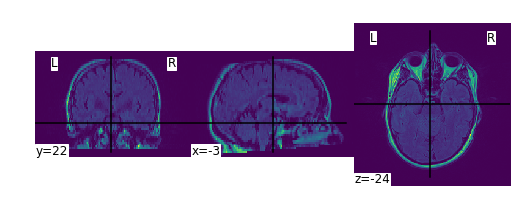

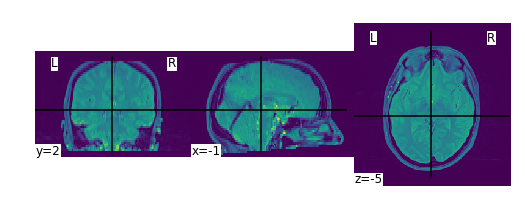

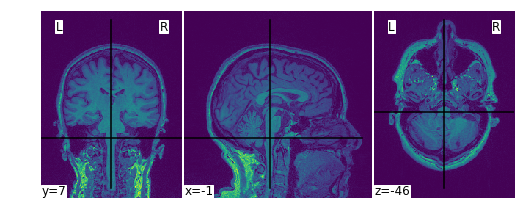

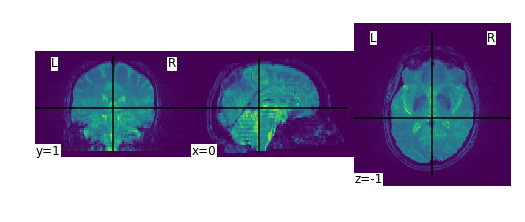

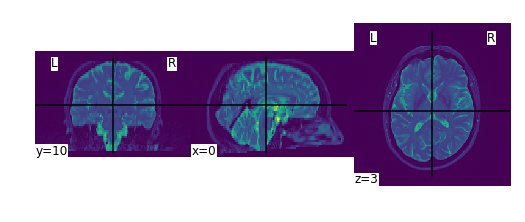

In [186]:
# Plotting anatomical images

from nilearn import plotting

nif = nifti_only.iloc[:5]
display([(row[1].filename,
          plotting.plot_img(image.load_img(row[1]['scans'])))
         for row in tqdm(nif.iterrows(), 'Plotting anatomical images')
 if 'anat' in row[1]['fpaths']])

In [ ]:


# # All ungrouped
# from nilearn import image

# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]


# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

# nif = nifti_only.iloc[:5]
# from nilearn import plotting
# display([(row[1].filename,
#           plotting.plot_img(image.load_img(row[1]['scans'])))
#          for row in nif.iterrows()
#  if 'anat' in row[1]['fpaths']])

In [179]:
# # All ungrouped
# from nilearn import image

# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]


# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

# # All ungrouped
# from nilearn import image

# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]


# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

# nif = nifti_only.iloc[:5]
# from nilearn import plotting
# display([(row[1].filename,
#           plotting.plot_img(image.load_img(row[1]['scans'])))
#          for row in nif.iterrows()
#  if 'anat' in row[1]['fpaths']])
# # test = df(zip(nifti_only.iterrows(), jsonfiles.iterrows()))

# # test = [behav, events, scan_infos, jsonfiles, nifti_only, dwi_only]
# # test = [list(((itm.groupby('dccid').get_group(grp).groupby('modality').get_group(mod)
# #               for grp in itm.groupby('dccid').groups) for mod in
# #              itm.groupby('dccid').get_group(grp).groupby('modality').groups))
# #         for itm in test]


# # jsonfiles, scan_infos= (scan_infos.drop([[row[0]
# #                                 for row in scan_infos.iterrows()
# #                                  if row[1].ext != '.json']][0], axis=0),
# #             scan_infos.drop([[row[0]
# #                                 for row in scan_infos.iterrows()
# #                                  if row[1].ext == '.json']][0], axis=0))
# # display(behav, events, scan_infos, jsonfiles, nifti_only, dwi_only, test)
# image.load_img(nifti_only.iloc[0]['scans'])
# # display(test.iloc[0][0].scans)

In [ ]:
# # All ungrouped
# from nilearn import image

# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]


# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

# nif = nifti_only.iloc[:5]
# from nilearn import plotting
# display([(row[1].filename,
#           plotting.plot_img(image.load_img(row[1]['scans'])))
#          for row in nif.iterrows()
#  if 'anat' in row[1]['fpaths']])

/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


[('sub-108391_ses-4_run-01_task-idle_FLAIR',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f386349ee10>),
 ('sub-108391_ses-4_run-01_task-idle_PD',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f3862c64f28>),
 ('sub-108391_ses-4_run-01_task-idle_T1w',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f3863918198>),
 ('sub-108391_ses-4_run-01_task-idle_T2star',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f386288f240>),
 ('sub-108391_ses-4_run-01_task-idle_T2w',
  <nilearn.plotting.displays.OrthoSlicer at 0x7f38632bc748>)]

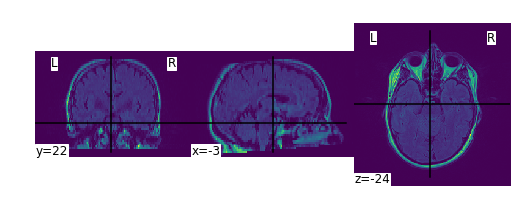

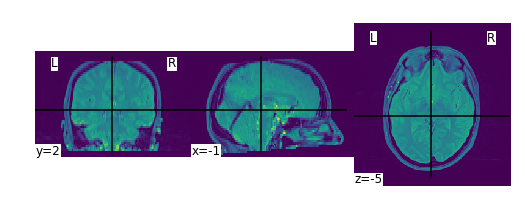

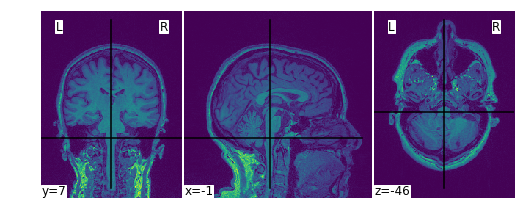

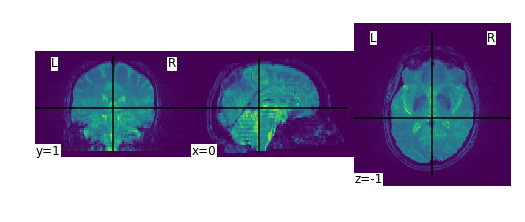

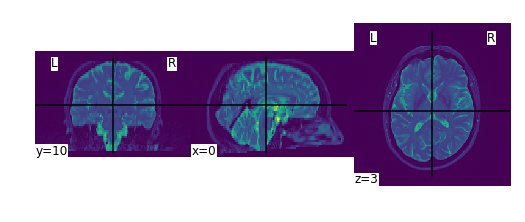

In [181]:
# nif = nifti_only.iloc[:5]
# from nilearn import plotting
# display([(row[1].filename,
#           plotting.plot_img(image.load_img(row[1]['scans'])))
#          for row in nif.iterrows()
#  if 'anat' in row[1]['fpaths']])

In [180]:
# epis = nifti_only.iloc[14]

In [ ]:
# ############ TODO: Group by modality ################3333

# subs_json = [jsonfiles.groupby('dccid').get_group(grp)
#              for grp in jsonfiles.groupby('dccid').groups]
# modgrps = [[sjson.groupby('modality').get_group(grp) for grp in sjson.groupby('modality').groups]
#            for sjson in subs_json]
# modgrps[4][0]
# # loaded_json = [pd.read_json(row[1].fpaths) for row in itm.iterrows()]
# #                for itm in subs_json]

# # loaded_json2 = [row[1].unique() for row in loaded_json.iterrows()]
# # loaded_json2 = [Counter(row[1]).most_common(1) for row in loaded_json.iterrows()]
# # loaded_json2

In [ ]:
# def _update_timestamp(path: os.PathLike, set_new: bool) -> None:
#     """
#     Context manager to set the timestamp of the path to plus or
#     minus a fixed delta, regardless of modifications within the context.

#     if set_new is True, the delta is added. Otherwise, the delta is subtracted.
#     """
#     stats = os.stat(path)
#     if set_new:
#         new_timestamp = (stats.st_atime_ns + _TIMESTAMP_DELTA, stats.st_mtime_ns + _TIMESTAMP_DELTA)
#     else:
#         new_timestamp = (stats.st_atime_ns - _TIMESTAMP_DELTA, stats.st_mtime_ns - _TIMESTAMP_DELTA)
#     try:
#         yield
#     finally:
#         os.utime(path, ns=new_timestamp)


# # Public Methods 